In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### TODO LIST

> * put feature enginering into function to be able to use both test and train data set.
* copy and use plot decision boundary function from this (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb) notebook to see how my simple dense model fails
> * find out the relationship between the `SibSp` and the `Parch` column.
* create more tf models for eg.> Conv1D, LSTM .... to get more experience.

In [2]:
pd.set_option('display.max_rows', 500)

### Imports

In [3]:
# Library imports
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluators
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
print(tf.__version__)

2.6.4


### Helper Functions

In [4]:
def create_model_checkpoint(model_name, save_path="model_experiment"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=1, save_best_only=True)

In [5]:
scaler = MinMaxScaler()


def feature_handler(data_frame, feature_importance=False):
    data_frame = data_frame.drop(labels=["Cabin", "Name", "Ticket"], axis=1)
    encoded_sex = pd.get_dummies(data_frame.Sex, prefix="sex")
    encoded_Pclass = pd.get_dummies(data_frame.Pclass, prefix="Pclass")
    encoded_Embarked = pd.get_dummies(data_frame.Embarked, prefix="Embarked")
    
    data_frame = pd.concat([data_frame,encoded_sex, encoded_Pclass, encoded_Embarked], axis=1)
    data_frame["Family"] = np.where((data_frame["SibSp"] > 0) |(data_frame['Parch'] > 0) , 1, 0)
    data_frame = data_frame.drop(["Sex", "Pclass", "Embarked", "SibSp", "Parch"], axis=1)
    data_frame = data_frame.fillna(data_frame["Age"].mean())
    data_frame[['Age', 'Fare']] = scaler.fit_transform(data_frame[['Age', 'Fare']])
    
    if feature_importance:
        data_frame = data_frame.drop(["Pclass_1", "Pclass_2", "Embarked_C", "Embarked_Q", "Embarked_S", "Family"], axis=1)
        
    data_frame.info()
    return data_frame

In [6]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  print(X.shape)
  print(y.shape)
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class 
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [7]:
def fit_and_score (models, X_train, X_val, y_train, y_val ):
    np.random.seed(883)
    model_scores= {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

In [8]:
# def create_submission_output ():


### Data section

Two types of data sets were created. The first one is a simple cleard data set the second one contains fewer features based on the RandomForestClassifier.feature_importance function.

In [9]:
# Imports dataset from Kaggle
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
len(train_df), len(test_df), train_df.shape, test_df.shape

(891, 418, (891, 12), (418, 11))

In [10]:
df = feature_handler(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Age          891 non-null    float64
 3   Fare         891 non-null    float64
 4   sex_female   891 non-null    uint8  
 5   sex_male     891 non-null    uint8  
 6   Pclass_1     891 non-null    uint8  
 7   Pclass_2     891 non-null    uint8  
 8   Pclass_3     891 non-null    uint8  
 9   Embarked_C   891 non-null    uint8  
 10  Embarked_Q   891 non-null    uint8  
 11  Embarked_S   891 non-null    uint8  
 12  Family       891 non-null    int64  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 41.9 KB


In [11]:
df_test = feature_handler(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   Fare         418 non-null    float64
 3   sex_female   418 non-null    uint8  
 4   sex_male     418 non-null    uint8  
 5   Pclass_1     418 non-null    uint8  
 6   Pclass_2     418 non-null    uint8  
 7   Pclass_3     418 non-null    uint8  
 8   Embarked_C   418 non-null    uint8  
 9   Embarked_Q   418 non-null    uint8  
 10  Embarked_S   418 non-null    uint8  
 11  Family       418 non-null    int64  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 16.5 KB


In [12]:
df_less = feature_handler(train_df, feature_importance=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Age          891 non-null    float64
 3   Fare         891 non-null    float64
 4   sex_female   891 non-null    uint8  
 5   sex_male     891 non-null    uint8  
 6   Pclass_3     891 non-null    uint8  
dtypes: float64(2), int64(2), uint8(3)
memory usage: 30.6 KB


In [13]:
df_less_test = feature_handler(test_df, feature_importance=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Age          418 non-null    float64
 2   Fare         418 non-null    float64
 3   sex_female   418 non-null    uint8  
 4   sex_male     418 non-null    uint8  
 5   Pclass_3     418 non-null    uint8  
dtypes: float64(2), int64(1), uint8(3)
memory usage: 11.1 KB


### Expoloring Data

<AxesSubplot:>

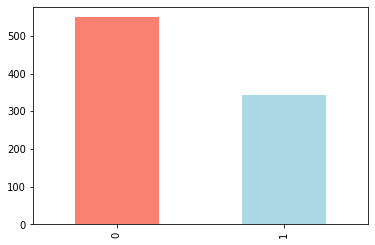

In [14]:
df["Survived"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [15]:
df.describe()

,PassengerId,Survived,Age,Fare,sex_female,sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,0.367921,0.062858,0.352413,0.647587,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783,0.397306
std,257.353842,0.486592,0.163383,0.096995,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876,0.489615
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,0.271174,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,0.367921,0.028213,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,668.500000,1.000000,0.434531,0.060508,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,891.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.isna().sum()

PassengerId    0
Survived       0
Age            0
Fare           0
sex_female     0
sex_male       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Family         0
dtype: int64

In [17]:
df[:10]

,PassengerId,Survived,Age,Fare,sex_female,sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Family
0,1,0,0.271174,0.014151,0,1,0,0,1,0,0,1,1
1,2,1,0.472229,0.139136,1,0,1,0,0,1,0,0,1
2,3,1,0.321438,0.015469,1,0,0,0,1,0,0,1,0
3,4,1,0.434531,0.103644,1,0,1,0,0,0,0,1,1
4,5,0,0.434531,0.015713,0,1,0,0,1,0,0,1,0
5,6,0,0.367921,0.016510,0,1,0,0,1,0,1,0,0
6,7,0,0.673285,0.101229,0,1,1,0,0,0,0,1,0
7,8,0,0.019854,0.041136,0,1,0,0,1,0,0,1,1
8,9,1,0.334004,0.021731,1,0,0,0,1,0,0,1,1
9,10,1,0.170646,0.058694,1,0,0,1,0,1,0,0,1


(13.5, -0.5)

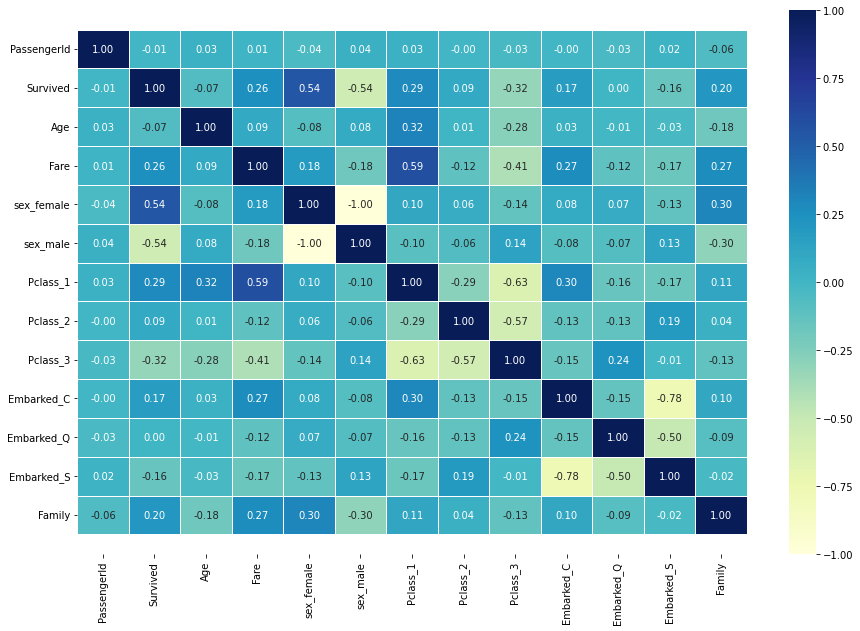

In [18]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(
            corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt=".2f",
            cmap="YlGnBu"
)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Creating Train and Test Split

In order to be able to test both versions of data sets (feature importance filtered fewer data and the base data set) two versions of X, and y data were created. 

In [19]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_less = df_less.drop("Survived", axis=1)
y_less = df_less["Survived"]

In [20]:
# Original data set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=883)
len(X_train), len(X_val), len(y_train), len(y_val)

(712, 179, 712, 179)

In [21]:
# Feature importance based data set
X_train_less, X_val_less, y_train_less, y_val_less = train_test_split(X_less, y_less, test_size=0.2, random_state=883)
len(X_train_less), len(X_val_less), len(y_train_less), len(y_val_less)

(712, 179, 712, 179)

# Modelling

### BASELINE_models

In [22]:
models = {
    "KNN": KNeighborsClassifier(),
    "Linear": LogisticRegression(),
    "RFC": RandomForestClassifier()
}

model_scores = fit_and_score(models=models, 
                          X_train=X_train, 
                          X_val=X_val, 
                          y_train=y_train, 
                          y_val=y_val)
model_scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'KNN': 0.5307262569832403,
 'Linear': 0.7262569832402235,
 'RFC': 0.7821229050279329}

### MODEL_1: Random Forest Classifier

In [23]:
# initial parameter to GridSearchCV
params = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 500, 1000]
}

# creating model
model_1_rfc = RandomForestClassifier()

GS_model_1_rfc = GridSearchCV(estimator=model_1_rfc,
                     param_grid=params,
                     cv=5)

# fit the model
GS_model_1_rfc.fit(X_train, y_train)

# pick the best model 
model_1_rfc_best = GS_model_1_rfc.best_estimator_
print(model_1_rfc_best)

# evaluate on validation data
print(model_1_rfc_best.score(X_val, y_val))

# predict
model_1_predictions = model_1_rfc_best.predict(df_test)


RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=1000)
0.7821229050279329


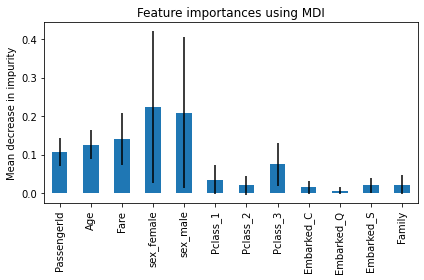

In [24]:
# get the feature importance see the bigger picture
feature_importance = model_1_rfc_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_1_rfc_best.estimators_], axis=0)
feature_names = [i for i in X_train]

forest_importances = pd.Series(feature_importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
# print(classification_report(y_test, y_preds))

### Model_2: Random Forest Classifier 
**trained on less data with feature importance**

In [26]:
# create model 
model_2_rfc = RandomForestClassifier()
GS_model_2_rfc = GridSearchCV(estimator=model_2_rfc, 
                              cv=5, 
                              param_grid=params )

# fit the model on less more important features
GS_model_2_rfc.fit(X_train_less, y_train_less )

# pick the best estimator
model_2_rfc_fi_best = GS_model_2_rfc.best_estimator_

# evaluate the model on validation data
model_2_rfc_fi_best.score(X_val_less, y_val_less)

# predict on Kaggle test data
model_2_predictions = model_2_rfc_fi_best.predict(df_less_test)

### MODEL_3: Simple DENSE model

In [27]:
tf.random.set_seed(883)
input_shape = X_train.shape[1]

# creating the simple dense model
# it is a very simple explonatory model with almost random layers and neurons
# this model works as a tensorflow baseline model
model_3_sdense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,input_shape)),
    tf.keras.layers.Dense(200, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(200, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# compile the simple dense model
model_3_sdense.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# fit the simple dense model
model_3_sdense.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[create_model_checkpoint("model_3_sdense")])

2022-09-14 10:30:54.487388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 10:30:54.614432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 10:30:54.615256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 10:30:54.616598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100
23/23 [==============================] - 2s 11ms/step - loss: 3.4708 - accuracy: 0.5478 - val_loss: 1.9736 - val_accuracy: 0.6089

Epoch 00001: val_loss improved from inf to 1.97356, saving model to model_experiment/model_3_sdense


2022-09-14 10:31:00.232840: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9386 - accuracy: 0.5449 - val_loss: 0.8413 - val_accuracy: 0.6089

Epoch 00002: val_loss improved from 1.97356 to 0.84133, saving model to model_experiment/model_3_sdense
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.6067 - val_loss: 1.5868 - val_accuracy: 0.4022

Epoch 00003: val_loss did not improve from 0.84133
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9210 - accuracy: 0.5492 - val_loss: 0.7962 - val_accuracy: 0.6201

Epoch 00004: val_loss improved from 0.84133 to 0.79615, saving model to model_experiment/model_3_sdense
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7818 - accuracy: 0.5562 - val_loss: 1.1217 - val_accuracy: 0.4246

Epoch 00005: val_loss did not improve from 0.79615
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.8648 - accuracy: 0.6110 - val_loss: 0.6310 - va

In [28]:
# load the best model and evaluate the result
model_3_sdense_best = tf.keras.models.load_model("./model_experiment/model_3_sdense/")
model_3_sdense_best.evaluate(X_val, y_val)

6/6 [==============================] - 0s 2ms/step - loss: 0.5408 - accuracy: 0.7263


[0.5407522320747375, 0.7262569665908813]

In [29]:
model_3_predictions = model_3_sdense_best.predict(df_test)
# model_3_predictions = tf.squeeze(model_3_predictions)
# model_3_predictions.shape
model_3_predictions = np.round(np.max(model_3_predictions, axis=1))

# Creating output to submit result

In [30]:
output = pd.DataFrame({"PassengerID": df_less_test.PassengerId, "Survived": model_3_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
